In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data\peyton_manning.csv")
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.strftime("%Y-%m-%d")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    364 non-null    object 
 1   y       364 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [3]:
df['y'].shift(1)

0           NaN
1      8.206584
2      8.188967
3      8.030735
4      8.054840
         ...   
359    7.980366
360    8.171317
361    7.977968
362    7.794823
363    8.304247
Name: y, Length: 364, dtype: float64

In [4]:
df.sort_values('time')

,time,y
0,2012-05-02,8.206584
1,2012-05-03,8.188967
2,2012-05-04,8.030735
3,2012-05-05,8.054840
4,2012-05-06,9.155145
...,...,...
359,2013-04-26,8.171317
360,2013-04-27,7.977968
361,2013-04-28,7.794823
362,2013-04-29,8.304247


In [5]:
for i in range(1,12):
    df[f'y{-i}'] = df['y'].shift(i)

df['target'] = df['y'].shift(-1)

In [6]:
df = df.dropna()

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [8]:
df.filter(like='y', axis=1)

,y,y-1,y-2,y-3,y-4,y-5,y-6,y-7,y-8,y-9,y-10,y-11
11,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,8.054840,8.030735,8.188967,8.206584
12,7.832411,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,8.054840,8.030735,8.188967
13,7.886833,7.832411,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,8.054840,8.030735
14,8.037866,7.886833,7.832411,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,8.054840
15,7.952615,8.037866,7.886833,7.832411,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145
...,...,...,...,...,...,...,...,...,...,...,...,...
358,7.980366,8.012018,7.731931,7.682482,7.536364,7.311886,7.853216,7.639642,7.568896,7.574045,7.486613,7.366445
359,8.171317,7.980366,8.012018,7.731931,7.682482,7.536364,7.311886,7.853216,7.639642,7.568896,7.574045,7.486613
360,7.977968,8.171317,7.980366,8.012018,7.731931,7.682482,7.536364,7.311886,7.853216,7.639642,7.568896,7.574045
361,7.794823,7.977968,8.171317,7.980366,8.012018,7.731931,7.682482,7.536364,7.311886,7.853216,7.639642,7.568896


In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class TimeSeriesML(BaseEstimator,RegressorMixin):
    def __init__(self) -> None:
        self.model = LinearRegression()

In [11]:
modelo = LinearRegression()
modelo.fit(df.filter(like='y', axis=1).values, df['target'].values.reshape(-1,1))
df['yhat'] = modelo.predict(df.filter(like='y', axis=1).values)

In [12]:
df

,time,y,y-1,y-2,y-3,y-4,y-5,y-6,y-7,y-8,y-9,y-10,y-11,target,yhat
11,2012-05-13,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,8.054840,8.030735,8.188967,8.206584,7.832411,8.244096
12,2012-05-14,7.832411,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,8.054840,8.030735,8.188967,7.886833,7.938985
13,2012-05-15,7.886833,7.832411,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,8.054840,8.030735,8.037866,7.929436
14,2012-05-16,8.037866,7.886833,7.832411,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,8.054840,7.952615,7.935111
15,2012-05-17,7.952615,8.037866,7.886833,7.832411,7.819234,7.709308,7.869402,7.956477,8.183397,8.349721,8.833317,9.155145,7.767687,7.916329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2013-04-25,7.980366,8.012018,7.731931,7.682482,7.536364,7.311886,7.853216,7.639642,7.568896,7.574045,7.486613,7.366445,8.171317,7.912863
359,2013-04-26,8.171317,7.980366,8.012018,7.731931,7.682482,7.536364,7.311886,7.853216,7.639642,7.568896,7.574045,7.486613,7.977968,7.840857
360,2013-04-27,7.977968,8.171317,7.980366,8.012018,7.731931,7.682482,7.536364,7.311886,7.853216,7.639642,7.568896,7.574045,7.794823,7.846673
361,2013-04-28,7.794823,7.977968,8.171317,7.980366,8.012018,7.731931,7.682482,7.536364,7.311886,7.853216,7.639642,7.568896,8.304247,7.858758


<Figure size 1600x500 with 0 Axes>

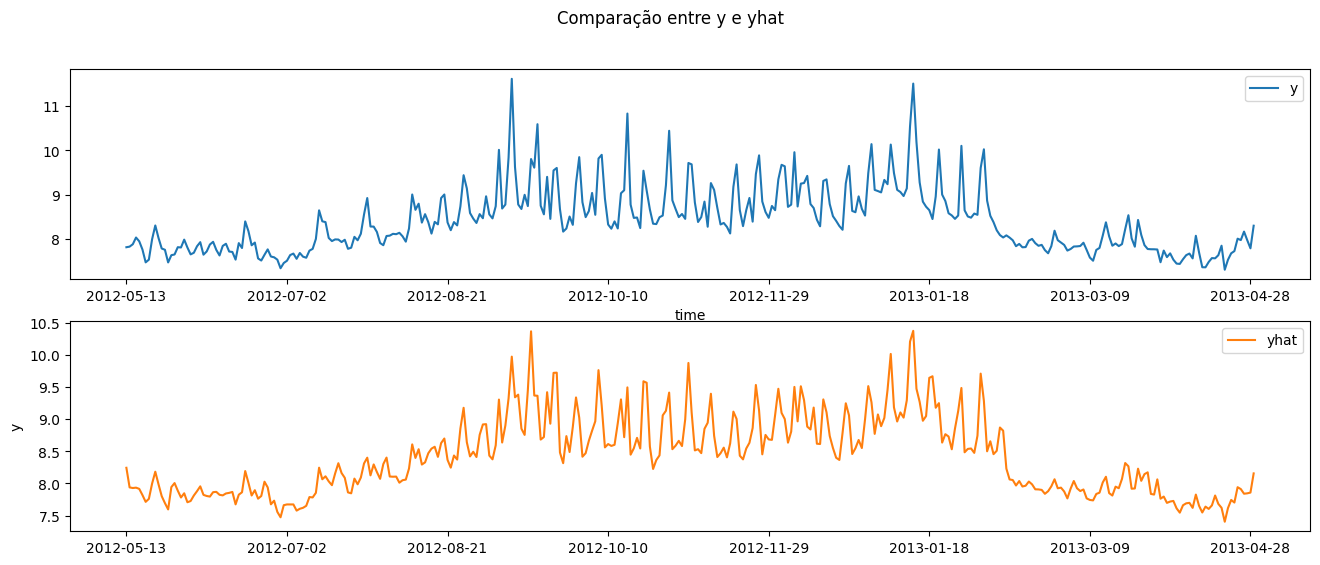

In [25]:
plt.figure(figsize=(16, 5))
df.plot(x='time',y=['y','yhat'],subplots=True,figsize=(16,6),sharex=False,sharey=False,title='Comparação entre y e yhat')
plt.xlabel('')
plt.ylabel('y')
plt.legend()
plt.show()

In [15]:
df['residuals'] = df['y'] - df['yhat']

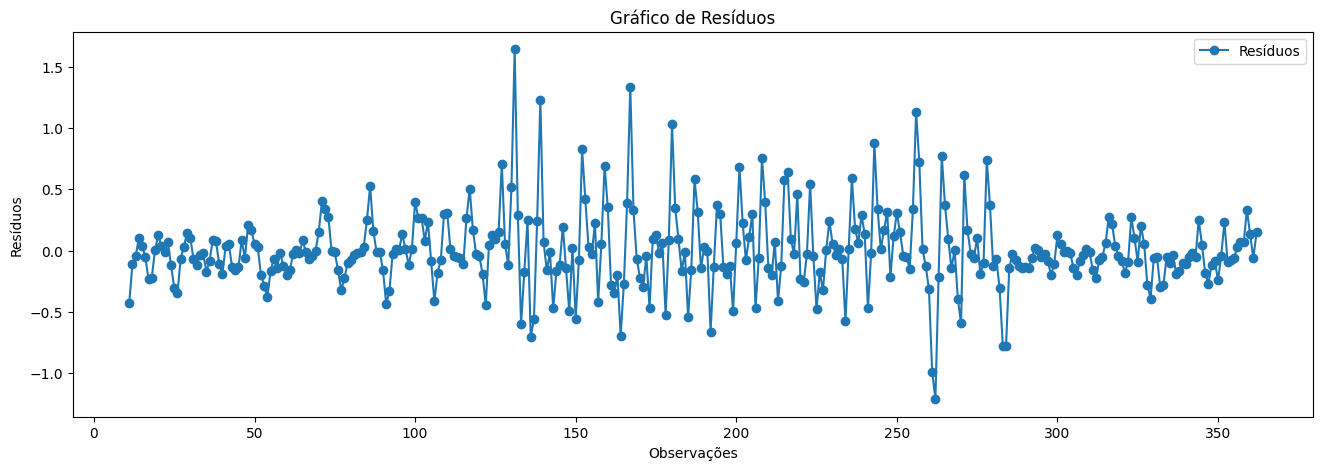

Ljung-Box p-value: l


In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Crie um gráfico dos resíduos
plt.figure(figsize=(16, 5))
plt.plot(df['residuals'], label='Resíduos', marker='o')
plt.title('Gráfico de Resíduos')
plt.xlabel('Observações')
plt.ylabel('Resíduos')
plt.legend()
plt.show()

# Teste de Ljung-Box
# A hipótese nula do teste é que as amostras são independentes
# Um baixo valor-p (< 0.05) sugere que os resíduos não são independentes
lb, p_value = acorr_ljungbox(df['residuals'], lags=[12])
print(f'Ljung-Box p-value: {p_value[0]}')